# Promoting financial products to bank customers 

In 2016, a retail bank sold several products (mortgage account, savings account, and pension account) to its customers.
It kept a record of all historical data, and this data is available for analysis and reuse.
Following a merger in 2017, the bank has new customers and wants to start some marketing campaigns. 

The budget for the campaigns is limited. The bank wants to contact a customer and propose only one product.


The marketing department needs to decide:
   * Who should be contacted?
   * Which product should be proposed? Proposing too many products is counter productive, so only one product per customer contact.
   * How will a customer be contacted? There are different ways, with different costs and efficiency.
   * How can they optimally use the limited budget?
   * Will such campaigns be profitable?
   
#### Predictive and prescriptive workflow

From the historical data, we can train a machine learning product-based classifier on customer profile (age, income, account level, ...) to predict whether a customer would subscribe to a mortgage, savings, or pension account.
* We can apply this predictive model to the new customers data to predict for each new customer what they will buy.
* On this new data, we decide which offers are proposed. Which product is offered to which customer through which channel:
   * a. with a greedy algorithm that reproduces what a human being would do
   * b. using an optimization model wih IBM Decision Optimization.
* The solutions can be displayed, compared, and analyzed.


<b>Table of contents</b>:

*  [Understand the historical data](#Understanding-the-historical-data)
*  [Predict the 2017 customer behavior](#Predict-the-2017-customer-behavior)
*  [Get business decisions on the 2017 data](#Get-business-decisions-on-the-2017-data)
*  [Conclusion on the decision making](#Conclusion)

The purpose of this Notebook is not to provide a perfect machine learning model nor a perfect optimization model.
The purpose is to show how easy it is to mix machine learning and optimisation research.


## How  decision optimization can help

Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

Prescriptive analytics takes that prediction to the next level by suggesting the optimal way to handle that future situation. Organizations gain a strong competitive advantage by acting quickly in dynamic conditions and making superior decisions in uncertain environments.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# Understand the historical data

Load 2016 historical data, analyze it visually, and train a classifier to predict 2017 sales.

##### Load the historical customer data with their purchases (Mortgage, Savings, and Pension).

In [6]:
# known_behaviors = pd.read_csv("https://raw.githubusercontent.com/vberaudi/utwt/master/known_behaviors2.csv")
# known_behaviors.head()

#known_behaviors.to_csv("data/known_behaviours.csv",index=False)

In [8]:
pd.options.display.max_columns = None

In [9]:
### These are historical data, for new customers only one function will be proposed
known_behaviors = pd.read_csv("data/known_behaviours.csv")
known_behaviors.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score,Mortgage,Pension,Savings
0,15,45,12,45,0,0,0,0,65,13453,2,33,36,0,4,2,1,14,19,7.602,0,0,0
1,16,43,12,43,0,0,0,0,65,13453,2,34,36,0,0,3,2,14,19,10.143,0,0,0
2,30,23,0,23,0,0,0,0,65,13453,2,30,36,0,1,0,0,14,19,0.000,0,0,0
3,42,35,8,35,1,0,0,0,65,13453,2,22,24,0,1,0,0,14,19,0.000,0,1,0
4,52,43,12,43,1,0,0,0,47,14124,3,40,48,3,1,0,0,16,35,0.000,0,1,0


#### Check the 2016 customers

In [10]:
a = known_behaviors[known_behaviors.Mortgage == 1]
b = known_behaviors[known_behaviors.Pension == 1]
c = known_behaviors[known_behaviors.Savings == 1]
print("Number of clients: %d" %len(known_behaviors))
print("Number of clients predicted to buy mortgage accounts: %d" %len(a))
print("Number of clients predicted to buy pension accounts: %d" %len(b))
print("Number of clients predicted to buy savings accounts: %d" %len(c))

Number of clients: 11023
Number of clients predicted to buy mortgage accounts: 1664
Number of clients predicted to buy pension accounts: 2456
Number of clients predicted to buy savings accounts: 4222


In [11]:
known_behaviors["nb_products"] = known_behaviors.Mortgage + known_behaviors.Pension + known_behaviors.Savings

In [13]:
known_behaviors["nb_products"].head()

0    0
1    0
2    0
3    1
4    1
Name: nb_products, dtype: int64

In [14]:
abc = known_behaviors[known_behaviors.nb_products > 1]
print("We have %d clients who bought several products" %len(abc))
abc = known_behaviors[known_behaviors.nb_products == 3]
print("We have %d clients who bought all the products" %len(abc))

We have 1650 clients who bought several products
We have 123 clients who bought all the products


In [15]:
products = ["Savings", "Mortgage", "Pension"]

##### Do some visual analysis of the historical data

It's possible to use pandas plotting capabilities, but it would require a new version of it. This Notebook relies on matplotlib as it is present everywhere.

In [16]:
def plot_cloud_points(df):
    figure = plt.figure(figsize=(20, 5))
    my_cm  = ListedColormap(['#bb0000', '#00FF00'])
    axes = {p : ('age', 'income') if p != "Mortgage"else ('members_in_household', 'loan_accounts') for p in products}
    for product in products:
        ax = plt.subplot(1, len(products), products.index(product)+1)
        ax.set_title(product)
        axe = axes[product]
        plt.xlabel(axe[0])
        plt.ylabel(axe[1])
        ax.scatter(df[axe[0]], df[axe[1]], c=df[product], cmap=my_cm, alpha=0.5)

In the following visualization, you can see the behavior of the 2016 customers for the three products.
The green color indicates that a customer bought a product; red indicates a customer did not buy a product.
The depth of the color indicates the number of purchases or non-purchases.

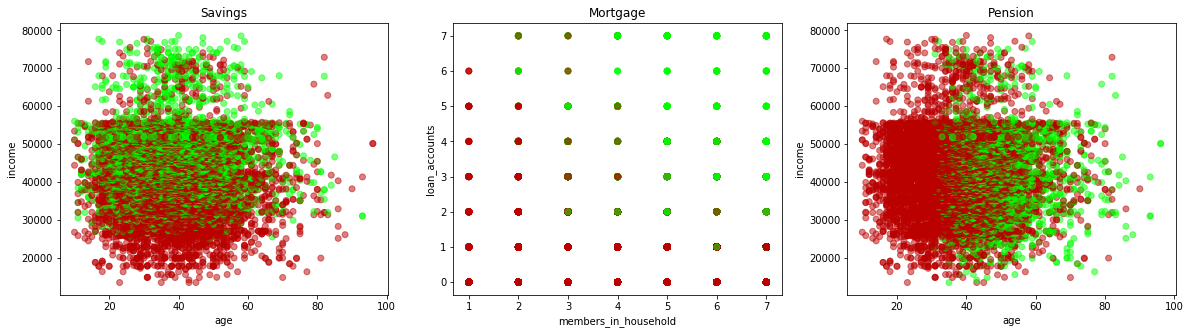

In [17]:
plot_cloud_points(known_behaviors)

### Understanding the 2016 customers
We can see that:
   * The greater a customer's income, the more likely it is s/he will buy a savings account.
   * The older a customer is, the more likely it is s/he will buy a pension account.
   * There is a correlation between the number of people in a customer's household, the number of loan accounts held by the customer, and the likelihood a customer buys a mortgage account. To see the correlation, look at the upper right and lower left corners of the mortgage chart.

# Predict the 2017 customer behavior
### Create and train a simple machine-learning algorithm to predict what the new clients will buy.

In [9]:
known_behaviors.columns

Index([u'customer_id', u'age', u'age_youngest_child', u'debt_equity',
       u'gender', u'bad_payment', u'gold_card', u'pension_plan',
       u'household_debt_to_equity_ratio', u'income', u'members_in_household',
       u'months_current_account', u'months_customer', u'call_center_contacts',
       u'loan_accounts', u'number_products', u'number_transactions',
       u'non_worker_percentage', u'white_collar_percentage', u'rfm_score',
       u'Mortgage', u'Pension', u'Savings', u'nb_products'],
      dtype='object')

Let's use the following columns as machine-learning features:

In [18]:
cols = ['age', 'income', 'members_in_household', 'loan_accounts']

In [19]:
X = known_behaviors[cols]
ys = [known_behaviors[p] for p in products]

In [20]:
X.head()

,age,income,members_in_household,loan_accounts
0,45,13453,2,4
1,43,13453,2,0
2,23,13453,2,1
3,35,13453,2,1
4,43,14124,3,1


We use a standard basic support gradient boosting algorithm to predict whether a customer might by product A, B, or C.

In [21]:
from sklearn import svm
from sklearn import ensemble

In [22]:
## Interesting to create separate one classifiers, instead of a multi-classifier.
classifiers = []
for i,p in enumerate(products):
    clf = ensemble.GradientBoostingClassifier()
    clf.fit(X, ys[i])
    classifiers.append(clf)

### New customer data and predictions

Load new customer data, predict behaviors using trained classifier, and do some visual analysis.
We have all the characteristics of the new customers, as for the 2016 clients, but the new customers did not buy any product yet.

##### Load new customer data

In [25]:
unknown_behaviors = pd.read_csv("data/unkown_behaviors.csv")

In [27]:
to_predict = unknown_behaviors[cols]

In [28]:
print("Number of new customers: %d" %len(unknown_behaviors))

Number of new customers: 2756


##### Predict behaviors of the new customers

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
# below: making a prediction for all products individually 
predicted = [classifiers[i].predict(to_predict) for i in range(len(products))]
for i,p in enumerate(products):
    to_predict[p] = predicted[i]
to_predict["id"] = unknown_behaviors["customer_id"]


##### Package new data with predictions for optimization

In [31]:
offers = to_predict
offers.head()

,age,income,members_in_household,loan_accounts,Savings,Mortgage,Pension,id
0,38,47958.0,4,1,0,0,0,44256
1,30,48606.0,2,4,0,0,0,46883
2,41,42152.0,4,0,0,0,0,32387
3,42,39788.0,3,3,0,0,0,25504
4,42,44365.0,6,2,0,1,0,35979


##### Do some visual analysis of the predicted data

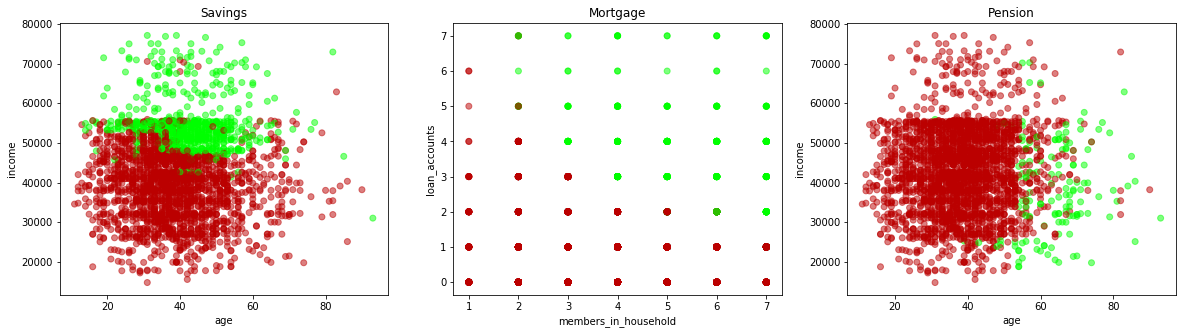

In [32]:
plot_cloud_points(offers)

The predicted data has the same semantic as the base data, with even more clear frontiers:
* for savings, there is a  clear frontier at $50K revenue.
* for pension, there is a clear frontier at 55 years old customers.

The training data contains customers who bought more than one product, let's see our prediction

In [33]:
a = offers[offers.Mortgage == 1]
b = offers[offers.Pension == 1]
c = offers[offers.Savings == 1]
print("Number of new customers: %d" %len(offers))
print("Number of customers predicted to buy mortgages: %d" %len(a))
print("Number of customers predicted to buy pensions: %d" %len(b))
print("Number of customers predicted to buy savings: %d" %len(c))

Number of new customers: 2756
Number of customers predicted to buy mortgages: 380
Number of customers predicted to buy pensions: 142
Number of customers predicted to buy savings: 713


In [36]:
to_predict["nb_products"] = to_predict.Mortgage + to_predict.Pension + to_predict.Savings

abc = to_predict[to_predict.nb_products > 1]
print("We predicted that %d clients would buy more than one product" %len(abc))
abc = to_predict[to_predict.nb_products == 3]
print("We predicted that %d clients would buy all three products" %len(abc))

We predicted that 112 clients would buy more than one product
We predicted that 0 clients would buy all three products


## Remarks on the prediction
The goal is to contact the customers to sell them only one product, so we cannot select all of them.
This increases the complexity of the problem: we need to determine the best contact channel, but also need to select which product will be sold to a given customer.  
It may be hard to compute this. In order to check, we will use two techniques:
   * a greedy algorithm
   * CPLEX, the IBM leading optimization solver.

In [38]:
offers.reset_index(inplace=True)

# Get business decisions on the 2017 data
## Assign campaigns to customers

* We have predicted who will buy what in the list of new customers.
* However, we do not have the budget to contact all of them. We have various contact channels with different costs and effectiveness.
* Furthermore, if we contact somebody, we don't want to frustrate them by proposing multiple products; we want to propose only one product per customer.

##### Some input data for optimization


In [39]:
# How much revenue is earned when selling each product
productValue = [200, 300, 400]
value_per_product = {products[i] : productValue[i] for i in range(len(products))}

# Total available budget
availableBudget = 25000

# For each channel, cost of making a marketing action and success factor.
# Difference between marginal and fixed cost, so it will result in different answers.
channels =  pd.DataFrame(data=[("gift", 20.0, 0.20), 
                               ("newsletter", 15.0, 0.05), 
                               ("seminar", 23.0, 0.30)], columns=["name", "cost", "factor"])

offersR = range(0, len(offers))
productsR = range(0, len(products))
channelsR = range(0, len(channels))

#### Using a greedy algorithm
* We create a custom algorithm that ensures 10% of offers are made per channel by choosing the most promising per channel. The algorithm then continues to add offers until the budget is reached.

In [49]:
## I personally would redo this and work with probabilities, where the probability of revenue exceeds the cost
## I would make the add - In saying that, there is a fixed budget, and it seems to be too small so you only
## have to consider those that have crossed the decision threshold.

In [40]:
gsol = pd.DataFrame()
gsol['id'] = offers['id']

budget = 0
revenue = 0

for product in products:
    gsol[product] = 0
   
noffers = len(offers)

# ensure the 10% per channel by choosing the most promising per channel
for c in channelsR: #, channel in channels.iterrows():
    i = 0;
    while (i< ( noffers // 10 ) ):
        # find a possible offer in this channel for a customer not yet done
        added = False
        for o  in offersR:
            already = False
            for product in products:   
                if gsol.get_value(index=o, col=product) == 1:
                    already = True
                    break
            if already:
                continue
            possible = False
            possibleProduct = None
            for product in products:
                if offers.get_value(index=o, col=product) == 1:
                    possible = True
                    possibleProduct = product
                    break
            if not possible:
                continue
            #print "Assigning customer ", offers.get_value(index=o, col="id"), " with product ", product, " and channel ", channel['name']
            gsol.set_value(index=o, col=possibleProduct, value=1)
            i = i+1
            added = True
            budget = budget + channels.get_value(index=c, col="cost")
            revenue = revenue + channels.get_value(index=c, col="factor")*value_per_product[product]            
            break
        if not added:
            print("NOT FEASIBLE")
            break

In [41]:
# add more to complete budget       
while (True):
    added = False
    for c, channel in channels.iterrows():
        if (budget + channel.cost > availableBudget):
            continue
        # find a possible offer in this channel for a customer not yet done
        for o  in offersR:
            already = False
            for product in products:   
                if gsol.get_value(index=o, col=product) == 1:
                    already = True
                    break
            if already:
                continue
            possible = False
            possibleProduct = None
            for product in products:
                if offers.get_value(index=o, col=product) == 1:
                    possible = True
                    possibleProduct = product
                    break
            if not possible:
                continue
            #print "Assigning customer ", offers.get_value(index=o, col="id"), " with product ", product, " and channel ", channel['name']
            gsol.set_value(index=o, col=possibleProduct, value=1)
            i = i+1
            added = True
            budget = budget + channel.cost
            revenue = revenue + channel.factor*value_per_product[product]            
            break
    if not added:
        print("FINISH BUDGET")
        break
    
print(gsol.head())

FINISH BUDGET
      id  Savings  Mortgage  Pension
0  44256        0         0        0
1  46883        0         0        0
2  32387        0         0        0
3  25504        0         0        0
4  35979        0         1        0


In [46]:
gsol.iloc[:,1:].sum(axis=1).shape

(2756,)

In [45]:
gsol.iloc[:,1:].sum(axis=1).sum()

1123

In [47]:
a = gsol[gsol.Mortgage == 1]
b = gsol[gsol.Pension == 1]
c = gsol[gsol.Savings == 1]

abc = gsol[(gsol.Mortgage == 1) | (gsol.Pension == 1) | (gsol.Savings == 1)]

print("Number of clients: %d" %len(abc))
print("Numbers of Mortgage offers: %d" %len(a))
print("Numbers of Pension offers: %d" %len(b))
print("Numbers of Savings offers: %d" %len(c))
print("Total Budget Spent: %d" %budget)
print("Total revenue: %d" %revenue)


comp1_df = pd.DataFrame(data=[["Greedy", revenue, len(abc), len(a), len(b), len(c), budget]], columns=["Algorithm","Revenue","Number of clients","Mortgage offers","Pension offers","Savings offers","Budget Spent"])


Number of clients: 1123
Numbers of Mortgage offers: 299
Numbers of Pension offers: 111
Numbers of Savings offers: 713
Total Budget Spent: 21712
Total revenue: 50800


The greedy algorithm only gives a revenue of \$50.8K.

#### Using IBM Decision Optimization CPLEX Modeling for Python

Let's create the optimization model to select the best ways to contact customers and stay within the limited budget.

In [31]:
import sys
import docplex.mp

##### Set up the prescriptive model



In [37]:
from docplex.mp.model import Model

mdl = Model(name="marketing_campaign", checker='on', context=context)

##### Define the decision variables
- The integer decision variables `channelVars`, represent whether or not a customer will be made an offer for a particular product via a particular channel.
- The integer decision variable `totaloffers` represents the total number of offers made.
- The continuous variable `budgetSpent` represents the total cost of the offers made.

In [38]:
channelVars = mdl.binary_var_cube(offersR, productsR, channelsR)

##### Set up the constraints
- Offer only one product per customer.
- Compute the budget and set a maximum on it.
- Compute the number of offers to be made.
- Ensure at least 10% of offers are made via each channel.

In [39]:
# At most 1 product is offered to each customer
mdl.add_constraints( mdl.sum(channelVars[o,p,c] for p in productsR for c in channelsR) <=1
                   for o in offersR)

# Do not exceed the budget
mdl.add_constraint( mdl.sum(channelVars[o,p,c]*channels.get_value(index=c, col="cost") 
                                           for o in offersR 
                                           for p in productsR 
                                           for c in channelsR)  <= availableBudget, "budget")  

# At least 10% offers per channel
for c in channelsR:
    mdl.add_constraint(mdl.sum(channelVars[o,p,c] for p in productsR for o in offersR) >= len(offers) // 10)

mdl.print_information()

Model: marketing_campaign
 - number of variables: 24804
   - binary=24804, integer=0, continuous=0
 - number of constraints: 2760
   - linear=2760
 - parameters: defaults


##### Express the objective

We want to maximize expected revenue, so we take into account the predicted behavior of each customer for each product.

In [40]:
obj = 0

for c in channelsR:
    for p in productsR:
        product=products[p]
        coef = channels.get_value(index=c, col="factor") * value_per_product[product]
        obj += mdl.sum(channelVars[o,p,c] * coef* offers.get_value(index=o, col=product) for o in offersR)

mdl.maximize(obj)

##### Solve with the Decision Optimization solve service

In [41]:
mdl.parameters.timelimit = 30

In [42]:
s = mdl.solve()
assert s, "No Solution !!!"

In [43]:
print(mdl.get_solve_status())
print(mdl.get_solve_details())

JobSolveStatus.OPTIMAL_SOLUTION
status  = integer optimal solution
time    = 0.893067 s.
problem = MILP
gap     = 0%



##### Analyze the solution

In [44]:
totaloffers = mdl.sum(channelVars[o,p,c] 
                      for o in offersR
                      for p in productsR 
                      for c in channelsR)
mdl.add_kpi(totaloffers, "nb_offers")

budgetSpent = mdl.sum(channelVars[o,p,c]*channels.get_value(index=c, col="cost") 
                                           for o in offersR 
                                           for p in productsR 
                                           for c in channelsR)
mdl.add_kpi(budgetSpent, "budgetSpent")

for c in channelsR:
    channel = channels.get_value(index=c, col="name")
    kpi = mdl.sum(channelVars[o,p,c] for p in productsR for o in offersR)
    mdl.add_kpi(kpi, channel)

for p in productsR:
    product = products[p]
    kpi = mdl.sum(channelVars[o,p,c] for c in channelsR for o in offersR)
    mdl.add_kpi(kpi, product)

In [49]:
mdl.report()

comp2_df = pd.DataFrame(data=[["CPLEX", mdl.objective_value, mdl.kpi_value_by_name('nb_offers'), mdl.kpi_value_by_name('Mortgage'), mdl.kpi_value_by_name('Pension'), mdl.kpi_value_by_name('Savings'), mdl.kpi_value_by_name('budgetSpent')]], columns=["Algorithm","Revenue","Number of clients","Mortgage offers","Pension offers","Savings offers","Budget Spent"])


* model marketing_campaign solved with objective = 72620.000
*  KPI: nb_offers   = 1218.000
*  KPI: budgetSpent = 24989.000
*  KPI: gift        = 275.000
*  KPI: newsletter  = 275.000
*  KPI: seminar     = 668.000
*  KPI: Savings     = 696.000
*  KPI: Mortgage    = 377.000
*  KPI: Pension     = 145.000


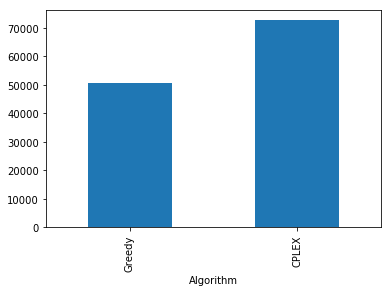

In [67]:
comp_df = comp1_df.append(comp2_df, ignore_index=True)
comp_df

comp_df.set_index("Algorithm", inplace=True)
    
my_plot = comp_df['Revenue'].plot(kind='bar')

With the mathematical optimization, we made a better selection of customers.

### What if our budget is increased?

If our manager is prepared to increase the allocated budget, they might want to know whether the additional budget campaigns would bring more revenue.

In [51]:
#get the hand on the budget constraint
ct = mdl.get_constraint_by_name("budget")

The following cell takes a relatively long term to run because the jobs are run sequentially. The standard subscriptions to DOcplexcloud solve service only allow one job at a time, but you can buy special subscriptions with parallel solves. If you have such a subscription, modify the following cell to benefit from it. 

In [52]:
res = []
for i in range(20):
    ct.rhs = availableBudget+1000*i
    s = mdl.solve()
    assert s, "No Solution !!!"
    res.append((availableBudget+1000*i, mdl.objective_value, mdl.kpi_value_by_name("nb_offers"), mdl.kpi_value_by_name("budgetSpent")))

In [53]:
mdl.report()

* model marketing_campaign solved with objective = 87120.000
*  KPI: nb_offers   = 1696.000
*  KPI: budgetSpent = 35983.000
*  KPI: gift        = 275.000
*  KPI: newsletter  = 275.000
*  KPI: seminar     = 1146.000
*  KPI: Savings     = 1136.000
*  KPI: Mortgage    = 405.000
*  KPI: Pension     = 155.000


In [54]:
pd.DataFrame(res, columns=["budget", "revenue", "nb_offers", "budgetSpent"])

,budget,revenue,nb_offers,budgetSpent
0,25000,72620.0,1218,24989.0
1,26000,74800.0,1262,25998.0
2,27000,76970.0,1305,26990.0
3,28000,79150.0,1349,27999.0
4,29000,81320.0,1392,28991.0
5,30000,82360.0,1436,30000.0
6,31000,83240.0,1479,30992.0
7,32000,84100.0,1522,31981.0
8,33000,84980.0,1566,32993.0
9,34000,85840.0,1609,33982.0


Due to the business constraints, we can address a maximum of 1680 customers with a \$35615 budget.
Any funds available above that amount won't be spent.
The expected revenue is \$87.1K.

### Dealing with infeasibility
What about a context where we are in tight financial conditions, and our budget is very low?
We need to determine the minimum amount of budget needed to adress 1/20 of our customers.

In [55]:
ct.rhs = 0

In [56]:
s = mdl.solve()

In [57]:
if not s:
    #rename the constraint with a "low" prefix to automatically put a low priority on it.
    ct.name = "low_budget"
    #setting all bool vars to 0 is an easy relaxation, so let's refuse it and force to offer something to 1/3 of the clients
    mdl.add_constraint(totaloffers >= len(offers)//20, ctname="high")
    
    # solve has failed, we try relaxation, based on constraint names
    # constraints are prioritized according to their names
    # if a name contains "low", it has priority LOW
    # if a ct name contains "medium" it has priority MEDIUM
    # same for HIGH
    # if a constraint has no name or does not match any, it is not relaxable.
    from docplex.mp.relaxer import Relaxer
    relaxer = Relaxer(prioritizer='match', verbose=True)

    relaxed_sol = relaxer.relax(mdl)
    relaxed_ok = relaxed_sol is not None
    assert relaxed_ok, "relaxation failed"
    relaxer.print_information()

-> relaxation #1 starts with priority: LOW, #relaxables=1
<- relaxation #1 succeeds: priority: LOW, #relaxables=1, obj=47580.0000006, #relaxations=1
* number of relaxations: 1
 - relaxed: low_budget, with relaxation: 15950.0000002
* total absolute relaxation: 15950.0000002


In [58]:
mdl.report()
print(mdl.get_solve_status())
print(mdl.get_solve_details())

* model marketing_campaign solved with objective = 47580.000
*  KPI: nb_offers   = 825.000
*  KPI: budgetSpent = 15950.000
*  KPI: gift        = 275.000
*  KPI: newsletter  = 275.000
*  KPI: seminar     = 275.000
*  KPI: Savings     = 309.000
*  KPI: Mortgage    = 374.000
*  KPI: Pension     = 142.000
JobSolveStatus.INFEASIBLE_SOLUTION
status  = optimal relaxed sum of infeasibilities
time    = 0.533871 s.
problem = MILP
gap     = 0%



We need a minimum of 15950\$ to be able to start a marketing campaign.
With this minimal budget, we will be able to adress 825 possible clients.

# Conclusion

#### Algorithm comparison
Here are the results of the 2 algorithms:

| Algorithm | Revenue | Number of clients | Mortgage offers | Pension offers | Savings offers | Budget Spent |
|-----------|---------|-------------------|-----------------|----------------|----------------|--------------|
| Greedy    |   50800 |              1123 |             299 |            111 |            713 |        21700 |
| CPLEX     |   72600 |              1218 |             381 |            117 |            691 |        25000 |

* As you can see, with Decision Optimization, we can safely do this marketing campaign to contact <b>1218 customers</b> out of the 2756 customers. 
* This will lead to a <b>\$91.5K revenue</b>, significantly greater than the \$49.5K revenue given by a greedy algorithm.
* With a greedy algorithm, we will:
   * be unable to focus on the correct customers (it will select fewer of them), 
   * spend less of the available budget for a smaller revenue.
   * focus on selling savings accounts that have the biggest revenue

### Marketing campaign analysis
* We need a <b>minimum of \$16K</b> to be able to start a valid campaign and we expect it will generate \$47.5K.

* Due to the business constraints, we will be able to address <b>1680 customers maximum</b> using a budget of \$36K. Any money above that amount won't be spent. The expected revenue is \$87K.


| Scenario | Budget | Revenue | Number of clients | Mortgage offers | Pension offers | Savings offers |
|----------|--------|---------|-------------------|-----------------|----------------|----------------|
| Standard | 25000  | 72600   | 1218              | 381             | 117            |  691           | 
| Minimum  | 16000  | 47500   | 825               | 374             | 142            | 309            |
| Maximum  | 35500  | 87000   | 1680              | 406             | 155            | 1119           |